In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

#the line below makes the plot as a pop-up, that can be saved
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm


from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.core.exceptions import NoHits

In [2]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef
import functions.recovstrue as myrvt

In [3]:
#Dimensions for the NEXT100 detector
veto_N100 = 20 # mm
rmax_N100 = 492 - veto_N100
zmin_N100 = veto_N100
zmax_N100 = 1205 - veto_N100

In [4]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaDS/'
max0nubbf = 999
maxselectron = 999
blobR = 21

## Opening TRACK Files - 0nubb

In [5]:
#0nubb files
track_list_0nubb = []

filepath_0nubb_tracks = filepath+f'0nubb/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R{blobR}mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb.columns  

#these are all the elements inside the file:

File /Users/halmamol/NEXT/files/NEXT100/beershebaDS/0nubb/tracks/21mm/next100.0nubb.600.skel_tracks.R21mm.h5 not good


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [6]:
#same for selectron files
track_list_selectron = []
filepath_selectron_tracks = filepath+f'/e-_roi/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,maxselectron):
    
    filename_selectron = filepath_selectron_tracks+f'next100.e-_roi.{nfile}.skel_tracks.R{blobR}mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks_selectron = pd.read_hdf(filename_selectron, 'Tracks')
    except:
        print('File {} not good'.format(filename_selectron))
        continue
        
    track_list_selectron.append(readfile_tracks_selectron)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_selectron = pd.concat([dt for dt in track_list_selectron]) 
tracks_selectron.columns  

#these are all the elements inside the file:

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

## Checking cuts

interested in selecting the events in/with:
- **Fiducial**: fiducial cut around the detector volume, of 2cm from the border
- **1Track**: in this case, considers the track with highest deposition
- **NoOverlap**: defined blobs in one trace should not overlap
- **ROI**: energy cut in the region of interest, between [2.445,2475]MeV

In [7]:
#Checking total amount of events, prior any selection
nevents_0nubb_total = tracks_0nubb.event.nunique()
Enevents_0nubb_total = np.sqrt(nevents_0nubb_total)
print(f'Initial amount of events for 0nubb: {nevents_0nubb_total} +- {Enevents_0nubb_total}')

nevents_selectron_total = tracks_selectron.event.nunique()
Enevents_selectron_total = np.sqrt(nevents_selectron_total)
print(f'Initial amount of events for selectrons: {nevents_selectron_total} +- {Enevents_selectron_total}')

Initial amount of events for 0nubb: 9791 +- 98.94948206029176
Initial amount of events for selectrons: 9766 +- 98.82307422864359


### 1 - FIDUCIAL CUT

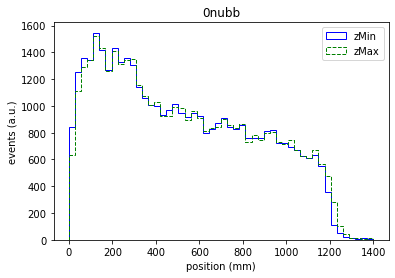

In [8]:
track_0nubb_zmin = tracks_0nubb.z_min
track_0nubb_zmax = tracks_0nubb.z_max

plt.hist(track_0nubb_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

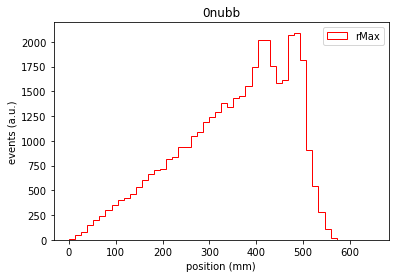

In [9]:
track_0nubb_rmax = tracks_0nubb.r_max

plt.hist(track_0nubb_rmax, bins = 50, range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

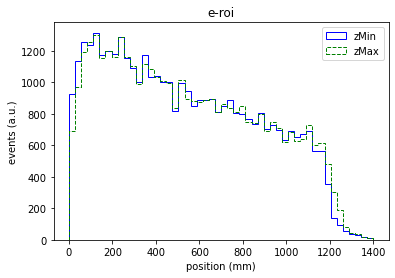

In [10]:
track_selectron_zmin = tracks_selectron.z_min
track_selectron_zmax = tracks_selectron.z_max

plt.hist(track_selectron_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

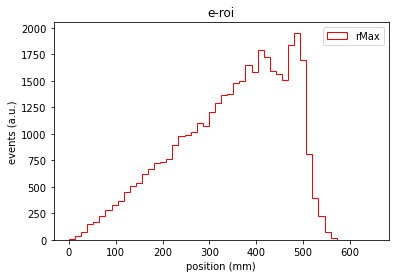

In [11]:
track_selectron_rmax = tracks_selectron.r_max

plt.hist(track_selectron_rmax, bins = 50,  range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

In [12]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- Rmax = {np.amax(track_0nubb_rmax)}')
print(f'- Zmin = {np.amax(track_0nubb_zmin)}')
print(f'- Zmax = {np.amax(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.amax(track_selectron_rmax)}')
print(f'- Zmin = {np.amax(track_selectron_zmin)}')
print(f'- Zmax = {np.amax(track_selectron_zmax)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- Rmax = {np.average(track_0nubb_rmax)}')
print(f'- Zmin = {np.average(track_0nubb_zmin)}')
print(f'- Zmax = {np.average(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.average(track_selectron_rmax)}')
print(f'- Zmin = {np.average(track_selectron_zmin)}')
print(f'- Zmax = {np.average(track_selectron_zmax)}')

MAX VALUE
0nubb
- Rmax = 578.5054018762487
- Zmin = 1455.0408750000001
- Zmax = 1463.791125
e-roi
- Rmax = 574.5768007847166
- Zmin = 1454.1785
- Zmax = 1463.777625
AVG VALUE
0nubb
- Rmax = 351.7306698027909
- Zmin = 518.2073825388853
- Zmax = 530.4413493560528
e-roi
- Rmax = 347.39148763628464
- Zmin = 530.638262605807
- Zmax = 545.7328724653246


In [13]:
#For the evaluation of the events out of fiducial limits it's necessary to do several steps

#First, check a list of events where at least 1 trace is out of the limits:

nonfiducial_list_0nubb = tracks_0nubb[~((tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_0nubb = tracks_0nubb[(tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_0nubb    = ~fiducial_tracks_0nubb.event.isin(nonfiducial_list_0nubb) 

# And finally I select the events with an asigned True from the previous line 
tracks_0nubb_fiducial = fiducial_tracks_0nubb[evt_fid_sel_0nubb]

In [14]:
#Now I do the same for single electron

nonfiducial_list_selectron = tracks_selectron[~((tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_selectron = tracks_selectron[(tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_selectron    = ~fiducial_tracks_selectron.event.isin(nonfiducial_list_selectron) 

# And finally I select the events with an asigned True from the previous line 
tracks_selectron_fiducial = fiducial_tracks_selectron[evt_fid_sel_selectron]

In [15]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_fiducial = tracks_0nubb_fiducial.event.nunique()
Enevents_0nubb_fiducial = np.sqrt(nevents_0nubb_fiducial)
nevents_selectron_fiducial = tracks_selectron_fiducial.event.nunique()
Enevents_selectron_fiducial = np.sqrt(nevents_selectron_fiducial)

ratio_fiducial_0nubb = 100*nevents_0nubb_fiducial/nevents_0nubb_total
Eratio_fiducial_0nubb = myef.ratio_error(ratio_fiducial_0nubb, nevents_0nubb_fiducial, nevents_0nubb_total, 
                                             Enevents_0nubb_fiducial, Enevents_0nubb_total)

ratio_fiducial_selectron = 100*nevents_selectron_fiducial/nevents_selectron_total
Eratio_fiducial_selectron = myef.ratio_error(ratio_fiducial_selectron, nevents_selectron_fiducial, nevents_selectron_total, 
                                             Enevents_selectron_fiducial, Enevents_selectron_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
--------!--------------!----------------!----------------


## 2 - Number of tracks

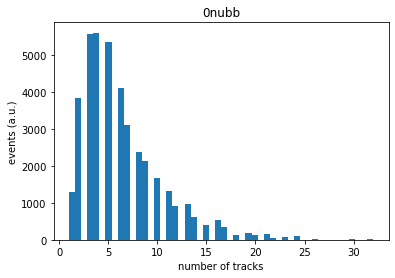

In [16]:
#Check the number of tracks with numb_of_tracks
ntracks_0nubb = tracks_0nubb.numb_of_tracks

plt.hist(ntracks_0nubb, bins = 50)
plt.xlabel('number of tracks')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

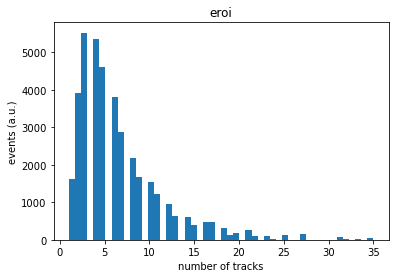

In [17]:
#Check the number of tracks with numb_of_tracks
ntracks_eroi = tracks_selectron.numb_of_tracks

plt.hist(ntracks_eroi, bins = 50)
plt.xlabel('number of tracks')
plt.ylabel('events (a.u.)')
plt.title('eroi')
plt.show()

In [18]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- #tracks = {np.amax(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.amax(ntracks_eroi)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- #tracks = {np.average(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.average(ntracks_eroi)}')

MAX VALUE
0nubb
- #tracks = 32
e-roi
- #tracks = 35
AVG VALUE
0nubb
- #tracks = 6.392468660065362
e-roi
- #tracks = 6.5645493627737785


In [19]:
#Therefore, I'm going to take the 1st 'trackID'
tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.trackID == 0]
tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.trackID == 0]

tracks_selectron_1track = tracks_selectron[tracks_selectron.trackID == 0]
tracks_selectron_1trackfid = tracks_selectron_fiducial[tracks_selectron_fiducial.trackID == 0]

In [20]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_1track = tracks_0nubb_1track.event.nunique()
Enevents_0nubb_1track = np.sqrt(nevents_0nubb_1track)
nevents_0nubb_1trackfid = tracks_0nubb_1trackfid.event.nunique()
Enevents_0nubb_1trackfid = np.sqrt(nevents_0nubb_1trackfid)

nevents_selectron_1track = tracks_selectron_1track.event.nunique()
Enevents_selectron_1track = np.sqrt(nevents_selectron_1track)
nevents_selectron_1trackfid = tracks_selectron_1trackfid.event.nunique()
Enevents_selectron_1trackfid = np.sqrt(nevents_selectron_1trackfid)

ratio_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial
Eratio_1trackfid_0nubb = myef.ratio_error(ratio_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_fiducial, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_fiducial)

eff_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_total
Eeff_1trackfid_0nubb = myef.ratio_error(eff_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_total)

ratio_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_fiducial
Eratio_1trackfid_selectron = myef.ratio_error(ratio_1trackfid_0nubb, nevents_selectron_1trackfid, nevents_selectron_fiducial, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_fiducial)

eff_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_total
Eeff_1trackfid_selectron = myef.ratio_error(eff_1trackfid_selectron, nevents_selectron_1trackfid, nevents_selectron_total, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')

print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
1TRACK.    6417        100.0+- 1.7654238044412536% 65.53978143192728 +- 1.0526649380958726%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
1TRACK.    6175        100.0+- 1.7996850826633901% 63.2295719844358 +- 1.0280190958814335%
--------!--------------!----------------!----------------


## 3 - No overlap

In [21]:
#Getting ovlp variable of the tracks, and selecting events with no ovlp

tracks_0nubb_ovlp = tracks_0nubb[tracks_0nubb.ovlp_blob_energy == 0.]
tracks_0nubb_ovlp1trackfid = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.ovlp_blob_energy == 0.]

tracks_selectron_ovlp = tracks_selectron[tracks_selectron.ovlp_blob_energy == 0.]
tracks_selectron_ovlp1trackfid = tracks_selectron_1trackfid[tracks_selectron_1trackfid.ovlp_blob_energy == 0.]

In [22]:
#Checking total amount of events, after overlap selection

nevents_0nubb_ovlp = tracks_0nubb_ovlp.event.nunique()
Enevents_0nubb_ovlp = np.sqrt(nevents_0nubb_ovlp)
nevents_0nubb_ovlp1trackfid = tracks_0nubb_ovlp1trackfid.event.nunique()
Enevents_0nubb_ovlp1trackfid = np.sqrt(nevents_0nubb_ovlp1trackfid)

nevents_selectron_ovlp = tracks_selectron_ovlp.event.nunique()
Enevents_selectron_ovlp = np.sqrt(nevents_selectron_ovlp)
nevents_selectron_ovlp1trackfid = tracks_selectron_ovlp1trackfid.event.nunique()
Enevents_selectron_ovlp1trackfid = np.sqrt(nevents_selectron_ovlp1trackfid)

ratio_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_1trackfid
Eratio_ovlp1trackfid_0nubb = myef.ratio_error(ratio_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_1trackfid, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_1trackfid)

eff_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_total
Eeff_ovlp1trackfid_0nubb = myef.ratio_error(eff_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_total)

ratio_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_1trackfid
Eratio_ovlp1trackfid_selectron = myef.ratio_error(ratio_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_1trackfid, 
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_1trackfid)

eff_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_total
Eeff_ovlp1trackfid_selectron = myef.ratio_error(eff_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_total,
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_total)
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')



--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
1TRACK.    6417        100.0+- 1.7654238044412536% 65.53978143192728 +- 1.0526649380958726%
OVLP       5720        89.13822658563191+- 1.6208977948747234%   58.42099887651925 +- 0.9722486246586135%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
1TRACK.    6175        100.0+- 1.7996850826633901% 63.2295719844358 +- 1.0280190958814335%
OVLP       5963        96.56680161943319+- 1.7532769705721076%   61.05877534302683 +- 1.0034780586956173%
--------!--------------!----------------!----------------


## 4 - ROI events

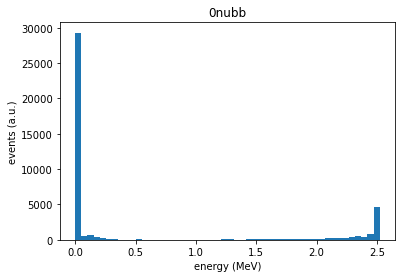

In [23]:
#Getting energy of the tracks
energy_0nubb = tracks_0nubb.energy

plt.hist(energy_0nubb, bins = 50)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

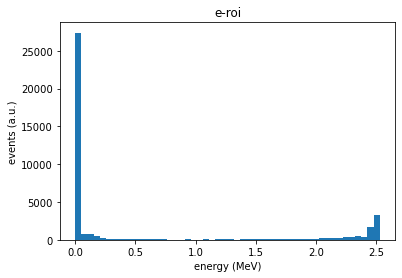

In [24]:
#Getting energy of the tracks
energy_selectron = tracks_selectron.energy

plt.hist(energy_selectron, bins = 50)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.show()

In [25]:
#Check limits of the Energy ROI 

emin = 2.40
emax = 2.54

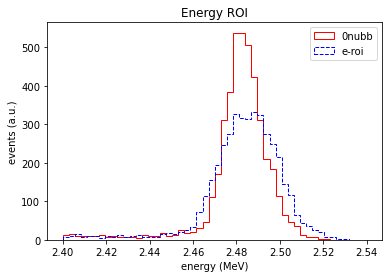

In [26]:
#Selecting events in the ROI
tracks_0nubb_ROI = tracks_0nubb[(tracks_0nubb.energy >= emin) & (tracks_0nubb.energy <= emax)]
tracks_0nubb_ROIovlp1trackfid = tracks_0nubb_ovlp1trackfid[(tracks_0nubb_ovlp1trackfid.energy >= emin) & (tracks_0nubb_ovlp1trackfid.energy <= emax)]

tracks_selectron_ROI = tracks_selectron[(tracks_selectron.energy >= emin) & (tracks_selectron.energy <= emax)]
tracks_selectron_ROIovlp1trackfid = tracks_selectron_ovlp1trackfid[(tracks_selectron_ovlp1trackfid.energy >= emin) & (tracks_selectron_ovlp1trackfid.energy <= emax)]


energy_0nubb = tracks_0nubb_ROIovlp1trackfid.energy
energy_selectron = tracks_selectron_ROIovlp1trackfid.energy

plt.hist(energy_0nubb, bins = 50, range = (emin, emax), color='red', histtype='step', label = '0nubb')
plt.hist(energy_selectron, bins = 50, range = (emin, emax), color='blue', histtype='step', label = 'e-roi', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Energy ROI')
plt.legend(loc=1);
plt.show()

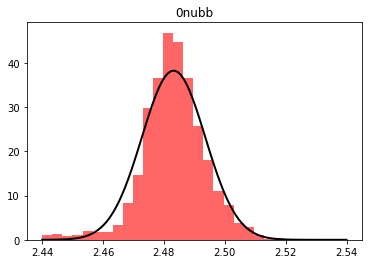

Fit results: mu = 2.4831767631781174,  std = 0.010410511627992168 


In [27]:
tracks_0nubb_zoom = tracks_0nubb_ROIovlp1trackfid[(tracks_0nubb_ROIovlp1trackfid.energy >= 2.44)]
energy_0nubb_zoom = tracks_0nubb_zoom.energy

mu, std = norm.fit(energy_0nubb_zoom)

# Plot the histogram.
plt.hist(energy_0nubb_zoom, bins=25, density=True, alpha=0.6, color='r')

# Plot the PDF.
x = np.linspace(2.44, emax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('0nubb')

plt.show()

print(f'Fit results: mu = {mu},  std = {std} ')

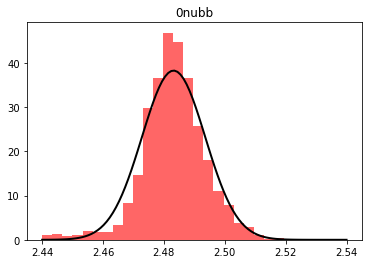

Fit results: mu = 2.483183435638094,  std = 0.010410512452849748 


In [28]:
ae, loce, scalee = skewnorm.fit(energy_0nubb_zoom)

# Plot the histogram.
plt.hist(energy_0nubb_zoom, bins=25, density=True, alpha=0.6, color='r')

# Plot the PDF.
x = np.linspace(2.44, emax, 100)
p = skewnorm.pdf(x, ae, loce, scalee)
plt.plot(x, p, 'k', linewidth=2)
plt.title('0nubb')

plt.show()

print(f'Fit results: mu = {loce},  std = {scalee} ')

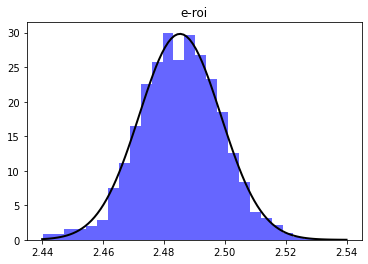

Fit results: mu = 2.485293199843235,  std = 0.013378694451507413 


In [29]:
tracks_selectron_zoom = tracks_selectron_ROIovlp1trackfid[(tracks_selectron_ROIovlp1trackfid.energy >= 2.44)]
energy_selectron_zoom = tracks_selectron_zoom.energy

mu, std = norm.fit(energy_selectron_zoom)

# Plot the histogram.
plt.hist(energy_selectron_zoom, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
x = np.linspace(2.44, emax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('e-roi')

plt.show()

print(f'Fit results: mu = {mu},  std = {std} ')

In [30]:
#Checking total amount of events, after ROI selection
nevents_0nubb_ROI = tracks_0nubb_ROI.event.nunique()
Enevents_0nubb_ROI = np.sqrt(nevents_0nubb_ROI)
nevents_0nubb_ROIovlp1trackfid = tracks_0nubb_ROIovlp1trackfid.event.nunique()
Enevents_0nubb_ROIovlp1trackfid = np.sqrt(nevents_0nubb_ROIovlp1trackfid)

nevents_selectron_ROI = tracks_selectron_ROI.event.nunique()
Enevents_selectron_ROI = np.sqrt(nevents_selectron_ROI)
nevents_selectron_ROIovlp1trackfid = tracks_selectron_ROIovlp1trackfid.event.nunique()
Enevents_selectron_ROIovlp1trackfid = np.sqrt(nevents_selectron_ROIovlp1trackfid)


ratio_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_ovlp1trackfid
Eratio_ROIovlp1trackfid_0nubb = myef.ratio_error(ratio_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_ovlp1trackfid, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_ovlp1trackfid)

eff_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_total
Eeff_ROIovlp1trackfid_0nubb = myef.ratio_error(eff_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_total)

ratio_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_ovlp1trackfid
Eratio_ROIovlp1trackfid_selectron = myef.ratio_error(ratio_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_ovlp1trackfid, 
                                             Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_ovlp1trackfid)

eff_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_total
Eeff_ROIovlp1trackfid_selectron = myef.ratio_error(eff_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_total,
                                                   Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_total)
    
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print(f'ROI        {nevents_0nubb_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_0nubb}+- {Eratio_ROIovlp1trackfid_0nubb}%   {eff_ROIovlp1trackfid_0nubb} +- {Eeff_ROIovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print(f'ROI        {nevents_selectron_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_selectron}+- {Eratio_ROIovlp1trackfid_selectron}%   {eff_ROIovlp1trackfid_selectron} +- {Eeff_ROIovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
1TRACK.    6417        100.0+- 1.7654238044412536% 65.53978143192728 +- 1.0526649380958726%
OVLP       5720        89.13822658563191+- 1.6208977948747234%   58.42099887651925 +- 0.9722486246586135%
ROI        4305        75.26223776223776+- 1.5185696831979307%   43.968951077520174 +- 0.8040701643457681%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
1TRACK.    6175        100.0+- 1.7996850826633901% 63.2295719844358 +- 1.0280190958814335%
OVLP       5963        96.56680161943319+- 1.7532769705721076%   61.05877534302683 +- 1.0034780586956173%

## Blob Assignation

### SIGNAL EVENTS

In [36]:
reco_0nubb_e = []

reco_0nubb_e = myrvt.blobassignation_notrue(tracks_0nubb, tracks_0nubb_ROIovlp1trackfid)

In [37]:
len(reco_0nubb_e[0])

4215

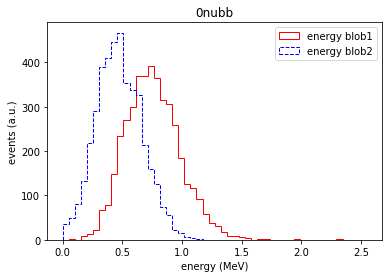

In [32]:
plt.hist(reco_0nubb_e[1], bins = 50, range = (0, 2.55), color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_0nubb_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

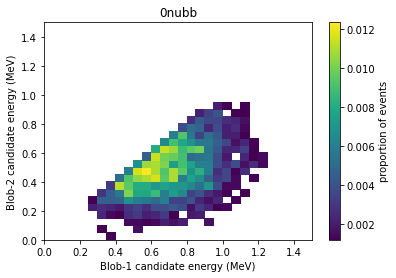

In [33]:
weights = myhf.get_weights(reco_0nubb_e[1], True)

plt.hist2d(reco_0nubb_e[1], reco_0nubb_e[2], weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob-1 candidate energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

### BACKGROUND EVENTS

In [38]:
reco_selectron_e = []

reco_selectron_e = myrvt.blobassignation_notrue(tracks_selectron, tracks_selectron_ROIovlp1trackfid)

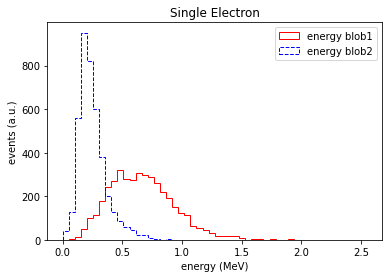

In [39]:
plt.hist(reco_selectron_e[1], bins = 50, range = (0, 2.55),color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_selectron_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

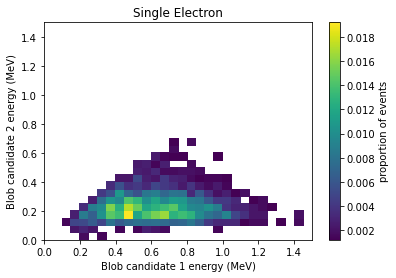

In [40]:
weights = myhf.get_weights(reco_selectron_e[1], True)

plt.hist2d(reco_selectron_e[1], reco_selectron_e[2], weights=weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

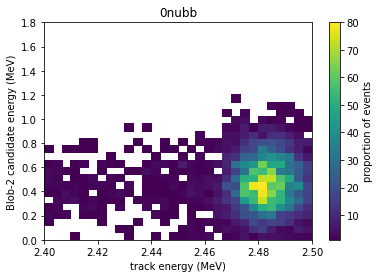

In [41]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[2], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

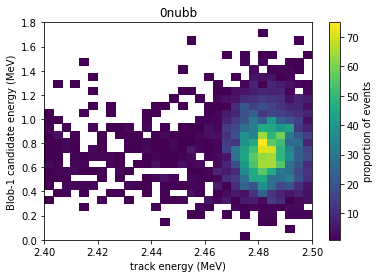

In [42]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[1], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-1 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

## Efficiency Values and FOM Estimation

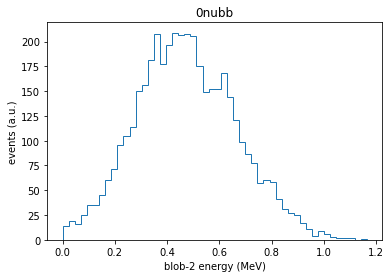

In [43]:
plt.hist(reco_0nubb_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

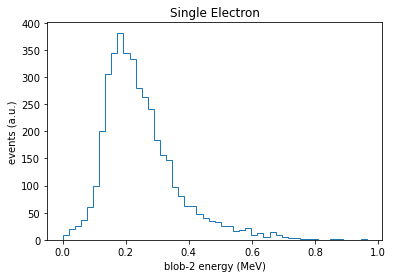

Total events 4065


In [44]:
plt.hist(reco_selectron_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.show()

print(f'Total events {len(reco_selectron_e[0])}')

Since I need to compare both simulations, I'm going to use the same energy cuts. Besides, they seem reasonable looking into the blob2 energy distribution:

In [45]:
blobcut_energy=[]
#in MeV
minEcut = 0.010
maxEcut = 0.600
stepsEcut = 0.010

#defining the vector with the cut values
blobcut_energy=myef.blobthreshold(minEcut,maxEcut,stepsEcut)

Now I'm going to take the information from reco_selectron_e[][], to see how many events with each cut I get:

In [46]:
blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron = [], [] 

blobcut_energy_nevents_0nubb = myef.nevents_afterthreshold(blobcut_energy, reco_0nubb_e)
blobcut_energy_nevents_selectron = myef.nevents_afterthreshold(blobcut_energy, reco_selectron_e)

blobcut_energy_nevents_0nubb = np.array(blobcut_energy_nevents_0nubb, dtype=np.float)
blobcut_energy_nevents_selectron = np.array(blobcut_energy_nevents_selectron, dtype=np.float)

Create now arrays containing the statistical uncertainty (sqrt from total amount of events)

In [47]:
blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error= [], []

blobcut_energy_nevents_0nubb_error = myef.sqrterror_array(blobcut_energy_nevents_0nubb)
blobcut_energy_nevents_selectron_error = myef.sqrterror_array(blobcut_energy_nevents_selectron)

Text(0.5, 0, 'blob-2 energy threshold (MeV)')

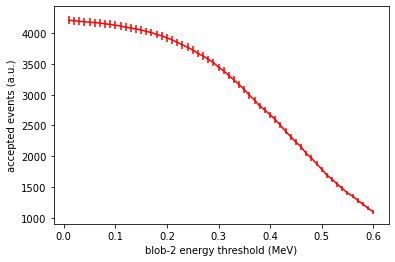

In [48]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,blobcut_energy_nevents_0nubb, yerr=blobcut_energy_nevents_0nubb_error, fmt = '-r')
plt.ylabel('accepted events (a.u.)')
plt.xlabel('blob-2 energy threshold (MeV)')
#plt.title('Cut efficiency')

Now that I have checked the accepted events for each energy cut, I'm going to compute the efficiency/background values:

In [49]:
fom_error, e_error, b_error = [], [], []

e, b, fom, e_error, b_error, fom_error = myef.efficiencyterms(blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron, 
                            blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error,
                            reco_0nubb_e, reco_selectron_e)

Text(0.5, 0, 'background rejection')

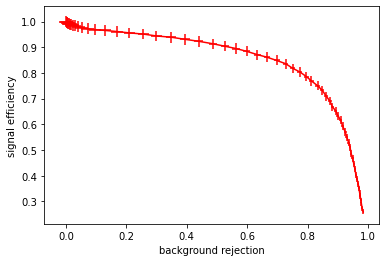

In [50]:
fig, ax = plt.subplots()
ax.errorbar(1-b,e, xerr=b_error, yerr=e_error, fmt = '-r')
plt.ylabel('signal efficiency')
plt.xlabel('background rejection')
#plt.title('Cut efficiency')

Text(0, 0.5, 'f.o.m.=e/sqrt(b)')

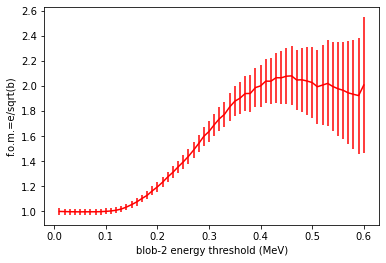

In [51]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,fom, yerr=fom_error,fmt = '-r')
plt.xlabel('blob-2 energy threshold (MeV)')
plt.ylabel('f.o.m.=e/sqrt(b)')
#plt.title('Cut efficiency')

In [52]:
myef.best_fom(e,b,fom,blobcut_energy)

Best fom is {2.0815907665067974}, that corresponds to:
- signal efficiency of 51.10%
- background acceptance of 6.03%
- energy threshold of 0.46 MeV
